### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2018 ###

# Optimal Skill-Based Worker Assignment

#### Noah Rhodes (nrhodes@wisc.edu), Alliot Nagle (acnagle@wisc.edu), and Liam Marshall (limarshall@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
  1. [Model 1: Simple Assignment](#2.A-Model-1:-Simple-Assignment)
  1. [Model 2: Variety Assignment](#2.B-Model-2:-Variety-Assignment)
  1. [Model 3: Binary Task Bundles](#2.C-Model-3:-Binary-Task-Bundles)
1. [Solution](#3.-Solution)
  1. [Model 1: Simple Assignment](#3.A-Model-1:-Simple-Assignment)
  1. [Model 2: Variety Assignment](#3.B-Model-2:-Variety-Assignment)
  1. [Model 3: Binary Task Bundles](#3.C-Model-3:-Binary-Task-Bundles)
1. [Results and Discussion](#4.-Results-and-discussion)
  1. [Model Solving Speed](#4.A-Model-Solving-Speed)
    1. [Simple Assignment Speed](#4.A.a-Simple-Assignment-Speed)
    1. [Variety Assignment Speed](#4.A.b-Variety-Assignment-Speed)
    1. [Binary Task Bundles Speed](#4.A.c-Binary-Task-Bundles-Speed)
    1. [Binary Task Bundles vs. Variety Assignment Speed](#4.A.d-Binary-Task-Bundles-vs.-Variety-Assignment-Speed)
  1. [Data Interpretation](#4.B-Data-Interpretation)
    1. [All workers have similar initial ability](#4.B.a-All-workers-have-similar-initial-ability)
    1. [All workers skilled at one task](#4.B.b-All-workers-skilled-at-one-task)
    1. [All workers skilled at one task; short project](#4.B.c-All-workers-skilled-at-one-task;-short-project)
1. [Conclusion](#5.-Conclusion)

### **Note:** Before running any code in this report, jump to the [Imports and Routines](#Imports-and-Routines) section and execute the cells there.</h1>

## 1. Introduction ##

An important aspect of project management is efficiently assigning workers to tasks.
There are many important considerations in this problem, _e.g._ decreasing worker boredom _[1]_, maximizing productivity, or increasing robustness to absent workers.

Our project focuses on minimizing the time to complete a project, given a set of workers and a set of tasks, with the unique twist that we account for _learning_: repeating a task can lead to decreasing time required to complete it.

We attempt to find an optimal schedule assigning workers to tasks.
Each task takes a defined amount of work to complete, and might need to be completed _many times_ (_e.g._ laying segments of pipe). The amount of time a worker spends on completing a task depends on his or her skill set.
In addition, when a worker completes a task, they become more skilled at performing that task, completing it more quickly in the future.

An optimal schedule could minimize the length of a project timeline by assigning workers to tasks that match the skills they have, or it might assign a less skilled worker to a job several times to in order for them to learn the skill and be more productive long-term.

The inspiration for this project came from work with Engineers Without Borders: as designs for a bridge, a microgrid, or a water system are finalized, a construction schedule must be planned.
Every household in the community contributes a person to the construction, resulting in a large workforce, but usually unskilled at the construction work. However, at low skill levels, productivity can increase rapidly as work proceeds.
A tool to better estimate how worker productivity may change over the course of a project would dramatically help in the creation of feasible project timelines. 

In larger projects where the number of tasks is significantly greater than the number of workers, we must decide how to assign our workers over the timeline of the project: do we have workers that specialize in a task and complete it quickly, or instead have workers who can generalize and complete a variety of tasks more slowly?

We developed a model to find an optimal schedule for worker assignment based on the amount of work each task requires and the skill level of each worker.
This model can be useful for a wide variety of applications; for example, developing a completion-time-optimal construction timeline, taking into account what specific combination of worker assignments will allow the project to be completed quickly.

We created synthetic data for our model, using very broad assumptions/estimates: sampling worker skill levels and learning speeds from uniform distributions restricted to a sensible range of values is more than sufficient for our purposes. Our goal is to prove that our model can be viable for a variety of assignment problems regardless of the initial data, rather than focus on a specific worker dataset.


Depending on the variety of types of tasks in a project, the quantity of those tasks, the number of workers, and any initial skills the workers have, we can expect a different optimal assignment of tasks to workers.
This leads to the question of whether workers should generalize or specialize in a skill, or how short-term optimal worker assignment compares to long-term optimal assignment.
Our project hopes to provide an answer to these questions and their dependency on initial conditions. 


----

[1]: Bhadury, J., and Z. Radovilsky. "Job rotation using the multi-period assignment model." _International Journal of Production Research_ 44.20 (2006): 4431-4444.

## 2. Mathematical model ##

Our project attempts to minimize project completion time, taking into account how worker productivity changes over time.

Our problem is a blend of assignment and planning, where we assign workers to tasks in the planning problem, and the speed of completing a task in the planning problems depends on the worker productivity, which changed based on previous assignments.
The complexity of our project is the result of this feedback between these two models, resulting in a considerable amount of logic constraints, a large solution space, and significant scaling challenges.
We attempt to find methods of modeling this problem as a flow problem, as both subsets of this problem can be modeled in this way, in order to remove the integer constraints on our assignments and model this problem as a Linear Program, rather than an integer program.
We begin with simplified models incorporating small sections of our target model.

Our eventual goal, represented as an optimization "in words":


>$
\begin{align*}
\min_{\text{worker assignment}}\quad & \textrm{Time to complete all tasks} \\
\text{subject to:}\quad & \text{Each task must be completed;}  \\ 
                        & \text{Each worker is assigned one task at a time;} \\
                        & \text{Worker productivity changes based on past assignments.} \\
\end{align*}
$

### 2.A Model 1: Simple Assignment ###

Our first model is a proof of concept that will help us see shortcomings in more complex models.
In this model, we have only one type of task, all workers complete tasks in the same amount of time, and no worker learning is modeled. Due to its extreme simplicity, it is easy to scale and a good starting point for adding other model characteristics.

Our initial model is below:

>$
\begin{align*}
\min_{x_{ijt},\,\lambda}\quad & \lambda \\
\text{s.t.}\quad & \sum\limits_{i=1}^N x_{ijt} \le 1 & \forall j \in \{1, \dots, W\}, \, t  \in \{1, \dots, T\} & & \text{(1)}\\ 
                 & \sum\limits_{j=1}^W \sum\limits_{t=1}^T x_{ijt} = 1 & \forall i \in \{1, \dots, N\} & & \text{(2)} \\
                 & \sum\limits_{j=1}^W \sum\limits_{t=1}^T x_{ijt}*t \leq \lambda & \forall i \in \{1, \dots, N\} & & \text{(3)} \\
\end{align*}
$

>Where
* $x_{ijt} \in \{0,1\}$ is 1 if worker $i$ is working on the $j$th task at time $t$
* $\lambda$ is the time the last task is completed
* $W$ is the number of workers
* $N$ is the number of tasks
* $T$ is an upper bound on the task completion time

>Notes on the constraints:
1. Each worker is limited to one task at a time
2. Each task is worked on exactly once
3. $\lambda$ is greater than or equal to the largest completion time of any task


In this model, the solution is trivial: all tasks should be evenly divided among all workers because any task assigned to any worker is completed in the same amount of time.  This allows us to easily verify this initial model.  

### 2.B Model 2: Variety Assignment ###

Using the first model as a basis, we wanted to include unique worker skills and a variety of task types.  For example, in the Engineers Without Borders project, we may have some workers who are more skilled in laying concrete for water tanks and others who are more skilled in digging and laying pipes for the water lines.  How do we assign these workers optimally when the number of workers skilled in a task does not match the work that must be accomplished in that task? 

The next step is to incorporate a variety of types of tasks and workers who have a different completion time for each task.  This requires some additional logic constraints that massively increased the complexity of solving this model in comparison to [Model 1](#2.A-Model-1:-Simple-Assignment).  Instead of requiring the sum along the task dimension of $x_{ijk}$ to be equal to one to enforce the completion of each task, we now have tasks that require an unknown amount of time to complete depending on the worker who is assigned.  Additionally, the constraint for enforcing each worker to be assigned no more than one task simultaneously is complicated by the variety of tasks that may assigned from any of the assignment groups.



> $
\begin{align*}
\min_{x_{ijkt},\,z_{ijkt},\,\lambda}\quad & \lambda \\
\text{s.t.}\quad & \sum\limits_{k=1}^{W}  \sum\limits_{t=1}^T z_{ijkt} \le 1 & \forall i \in \{1, \dots, N\}, \,j \in \{1, \dots, v\} & & \text(1) \\
                 & \sum\limits_{i=1}^N \sum\limits_{j=1}^V x_{ijkt} = 1  & \forall k \in \{1, \dots , W\} , \,t \in \{1, \dots, T\} & & \text{(2)}\\
                 & \sum\limits_{i=1}^N \sum\limits_{k=1}^W \sum\limits_{t=1}^T x_{ijkt} = n_j & \forall j \in \{1, \dots, V\} & & \text(3) \\
                 & \sum\limits_{t=1}^T x_{ijkt}*(t+w_{kj}) \le \lambda & \forall i \in \{1, \dots, N\}, \,j \in \{1, \dots, V\}, \,k \in \{1, \dots , W\} & & \text{(4)}\\
                 & z_{ijkl} \ge x_{ijkt} & \forall i \in \{1, \dots, N\}, \,j \in \{1, \dots, V\}, \,k \in \{1, \dots , W\}, \,t \in \{1, \dots, T\}, \, l \in \{t, \dots ,w_{kj}\} & & \text{(5)}\\
\end{align*}
$

> Where
* $z_{ijkt} \in \{0, 1\}$ is $1$ if worker $i$ is working on the $k$th task of type $j$ at time $t$.
* $x_{ijkt} \in \{0, 1\}$ is $1$ if worker $i$ starts the $k$th task of type $j$ at time $t$.
* $\lambda$ is the time the last task is completed
* $w_{ij}$ is the speed with which worker $i$ completes task $j$.
* $n_i$ is the work quota for task type $i$.
* $W$ is an number of workers
* $N$ is the maximum quota in $n$
* $V$ is the number of task types
* $T$ is an upper bound on the number of timesteps considered in the model.  

> Notes on the constraints:
1. Each worker is limited to one task at a time
2. Each task is started exactly once
3. We must meet work quotas for each task type
4. $\lambda$ is greater than or equal to largest completion time of any task
5. Enforces the relation between starting a task and whether a worker is currently working on the task


As we developed this model, we realized it was similar to a quadratic assignment problem. A quadratic assignment problem follows this format: 

> *Assign facilities to fixed locations. The facilities have known communication requirements and incurred costs depend on the distances between the facilities.* _[1]_

In our example, each worker is a "facility" and each task type is a "location".  We have "communication constraints" and costs each time a worker is assigned as task in each "location".  As a result, we have a quadratic assignment that contains on the order of $W_{workers}*V_{task types}*N_{tasks}*T_{time steps}$. To apply a model to a useful scenario size, we would require  $\approx 10^5$ boolean variables, a problem size that requires far more computation time than is reasonable for this project.  Further analysis of the relative speeds of each model is shown in [Section 4.1](#4.1-Model-Solving-Speed).

Our original goal was to create an amalgamation of an assignment problem with a planning problem, both Linear Programs, that could also be modeled as an LP, or at least solve on a similar timescale. To do this, we need to relax some requirements to our problem in order attempt to address our primary focus: how do worker skills change over the course of a project as they are assigned a variety of tasks?

---

[1]: Lessard, UW ECE 524 (Spring 2018), Lecture 22 ([slides](http://www.laurentlessard.com/teaching/cs524/slides/22%20-%20more%20models,%20QAP%20and%20SOS.pdf)).

### 2.C Model 3: Binary Task Bundles ###

In our third model, we relax the requirement of finding an ordering of the tasks each worker completes.  We assume that the learning process for each worker will depend on the number of times that task is completed and not on the temporal density of assignments. This allows us to stop modeling the discrete times when a worker is assigned a task and only consider a boolean: 'is this task assigned to this worker'.

However, we will not have the option to enforce the ordering in which the tasks take place and so will not be able to set prerequisite task completions.  As a result, our problem no longer fully resembles a planning problem and is an assignment problem with nonlinear cost.


>$
\begin{align*}
\min_{x \in \{0, 1\}^{W\times J\times T},\,\lambda \ge 0}\quad & \lambda \\
\text{s.t.}\quad & \sum_{t=1}^{T} \sum_{i=1}^{W} t\,x_{i,j,t} \ge q_j & \forall j \in \{1, \dots, J\} & & \text{(1)}\\
                 & \sum_{j=1}^{J} \sum_{t=1}^{T} B(j, t)\,x_{i,j,t} \le \lambda & \forall i \in \{1, \dots, W\} & & \text{(2)}\\
                 & \text{SOS1}\,\{ x_{i,j,t}\;\forall t \in {1, \dots, T} \} & \forall i \in \{1, \dots, W\},\,j \in \{1, \dots, J\} & & \text{(3)}\\
\end{align*}
$

>where
* $x_{i,j,t} \in \{0, 1\}$ is $1$ if worker $i$ is working on task $j$ at time $t$.
* $\lambda$ is the time the slowest worker takes to complete all their tasks.
* $W$ is the number of workers.
* $J$ is the number of tasks.
* $T$ is the maximum number of units of work per a (worker, job) combination considered in the problem.
* $q_j$ is the work unit quota for task $j$.
* $B(j, t)$ is the time required to perform job $j$ $t$ times; this might scale non-linearly with $t$ as a worker learns that job.

>Notes on the constraints:
1. We must meet work quotas $q$.
2. Lower-bound $\lambda$ by every worker's completion time; $\lambda$ is the time for the slowest worker to complete all tasks.
3. Only one binary time may be active per job + worker combination.

We are now able to model our problem as a min-cost flow problem. The Worker - Task connections are the number of times worker $i$ is assigned task type $j$.  These assignments are constrained to be integers, and the cost is the time the workers needs to complete that quantity of tasks.  Task - Quota connections aggregate the number of times each task type has been assigned.  The Quotas - Task End connections enforce the number of times each task must be completed.  These final connections force a certain number of assignments to "flow" through the network, and we minimize the cost of this flow by distributing the task assignments between all workers. 

![](https://i.imgur.com/rmpeUqr.png)

Unfortunately, the objective is nonlinear once we model worker learning, meaning that we need Boolean constraints on our worker assignments.  We no longer have a Quadratic Assignment problem and instead have a mixed integer program. It is not an LP, but it should solve considerably faster than Model 2.

## 3. Solution ##

Each of our models was created in Julia, along with a method of viewing the worker schedule for each model.  An analysis comparing the models follows in the [results and discussion](#4.-Results-and-discussion).

### 3.A Model 1: Simple Assignment

Our first model is very straightforward: a basic assignment optimization which evenly distributes tasks between workers.

In [7]:
#########################
# Simple Assignment Model
#########################
N = 100 # tasks
M = 9 # workers
T = N #upper bound on project completion

m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, x[1:N, 1:M, 1:T], Bin)
@variable(m, last)

# due to the following two constraints, this just selects the time
# when x[j, i, t] = 1, since x[j, :, :] has only one nonzero elemnt
@expression(m, start_t[j=1:N], sum(x[j, i, t] * t for i=1:M for t=1:T))

# at most one job per timestep per person
@constraint(m, [t=1:T, i=1:M], sum(x[:, i, t]) <= 1)

# each task is only worked on once
@constraint(m, [j=1:N], sum(x[j, :, :]) == 1)

# min { max_j end_t[j] }
@constraint(m, [j=1:N], last >= start_t[j])

@objective(m, Min, last)

solve(m)

println("Minimum time to complete tasks: ", getvalue(last))

Academic license - for non-commercial use only
Minimum time to complete tasks: 12.0


We can then show a work schedule for each worker:

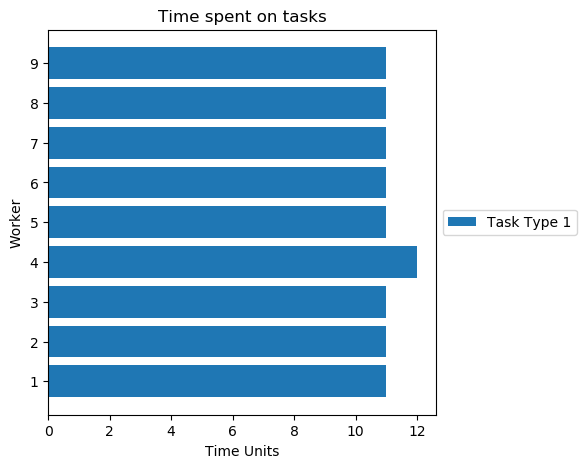

In [8]:
workSchedule = getvalue(x)

# task_dur is a matrix where the rows represent workers and columns represent the total time spent working
# on a particular task type
# task_dur = sum(schedule[:, i, :] for i=1:M)
task_dur = zeros(M)
for i=1:M
    task_dur[i] = sum(workSchedule[:, i, :])
end
plot_task_dur(M, 1, task_dur); show()


This model performs as expected.  If each worker completes every job at the same pace, the most efficient method of dividing the work is to have each worker be assigned the same number of tasks. The next step is to model the variety of skills each worker may have.

### 3.B Model 2: Variety Assignment
In our second model, we allow tasks to require different amounts of work to be completed and give each worker a 'speed' at which they can complete that task.

In [8]:
####################
# Variety Assingment
####################

# Task/Worker Parameters
###############################
N = rand(8:12,1, 5)  # 5 task types, with quotas ranging from 15 to 25
W = rand(1:10, 6, 5)  # 6 workers with task completion speeds ranging from 1 to 10

n = maximum(N) #max number of tasks for a category
v = size(N,1) # number of types of tasks

## Each row of W is a worker, and the column is the time required for the worker to complete that task
w = size(W,1) #number of workers

T = convert(Int64,maximum(W)*sum(N)) #upper bound on project completion

# Solver
###############################
m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, x[1:n, 1:v, 1:w, 1:T], Bin) # true when a worker starts a task
@variable(m, z[1:n, 1:v, 1:w, 1:T], Bin) #true if a worker is working on a task (extends x with task length)

@variable(m, last)

#If a worker starts a task at time t, z if true until the tasks completes
for i=1:n
    for j=1:v
        for k=1:w
            for t=1:T
                if t < T-convert(Int64,W[k,j])
                    @constraint(m, [l=1:convert(Int64,W[k,j])], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                else
                    @constraint(m, [l=0:T-t], z[i,j,k,t+l] >= x[i,j,k,t])  
                end
            end
        end
    end
end

#only one task in z can be worked simultaneously
@constraint(m, [k=1:w, t=1:T], sum(z[:,:,k,t]) <= 1)

#expression is used as an epigraph to find the end time of the last task
@expression(m, end_t[j=1:n, k=1:v, i=1:w, t=1:T], (z[j,k,i,t])*(t+W[i,k]))
@expression(m, start_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t) for t=1:T))

# at most one job per timestep per person
@constraint(m, [t=1:T, i=1:w], sum(x[:, :, i, t]) <= 1)

# each task is only worked on once and all tasks are completed
@constraint(m, [j=1:n, i=1:v], sum(x[j, i, :, :]) <= 1)
@constraint(m, [i=1:v], sum(x[:,i,:,:]) == N[i])

# min { max_j end_t[j] }
@constraint(m, [j=1:n, k=1:v, i=1:w, t=1:T], last >= end_t[j,k,i,t])


@objective(m, Min, last)
status = solve(m)
timer = getsolvetime(m)
println("The minimum completion time is: ", getobjectivevalue(m))

Academic license - for non-commercial use only
The minimum completion time is: 17.0


The solution to this model provides us with a worker schedule that is the optimal distribution of tasks according the speed that each worker completes each task.

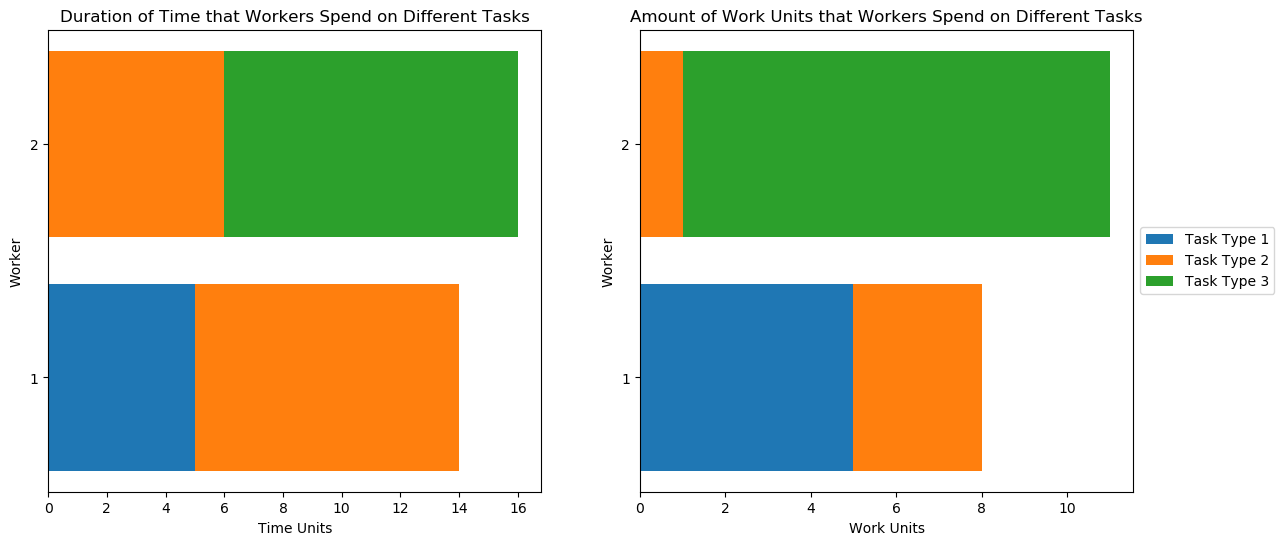

In [71]:
schedule = getvalue(z)
start_time = getvalue(x)

# task_dur is a matrix where the rows represent workers and columns represent the total time spent working
# on a particular task type
task_dur = zeros(size(W, 1), v)

# task_amt is a matrix where the rows represent workers and columns represent task types. Each entry is
# the total work completed for each task type by each worker.
task_amt = zeros(size(W, 1), v)

for i=1:w
    for j=1:v
        task_dur[i, j] = sum(schedule[:, j, i, :])
        task_amt[i, j] = sum(start_time[:, j, i, :])
    end
end

plot_tasks(w, n, task_dur, task_amt);

Here, we can see that tasks tend to be distrubted across more than one worker, but from repeated runs we see that rarely do more than two workers work on a task.  The work is evenly distributed across the abilitiy levels of of each worker according the quotas of each task type.  

### 3.C Model 3: Binary Task Bundles

This model no longer specifies the time when a worker begins a task and instead decides how many times each task type is assigned to a worker. Here we incorporate a worker learning model to estimate how a worker's productivity on a task type increases overtime. To model the worker learning, we assume each additional task can be completed according to a linearly decreasing function, with a cap on the maximum speed that can be achieved.

We define the time required to complete task $i$ after having previously completed $n$ units of that task as:
$$
t_i(n) = \max(m_i,\ l_i - t s_i)
$$

where
* $l_i$ is the initial time required to complete task $i$
* $m_i$ is the minimum time required to complete task $i$
* $s_i$ is the decrease in completion time for each unit of work, or "learning speed", for task $i$.

The time required for a worker to complete $N$ tasks of type $i$ is then
$$
B_i(N) = \sum_{n=0}^{N-1} t_i(n).
$$

In [9]:
# Parameters
############
quotaRange = 4:10
initialTaskLengthRange =  30:50
learningSpeedRange = 4:10
learningCurveMinLengthRange = 30:50
n_workers = 5
m_tasks = 8;

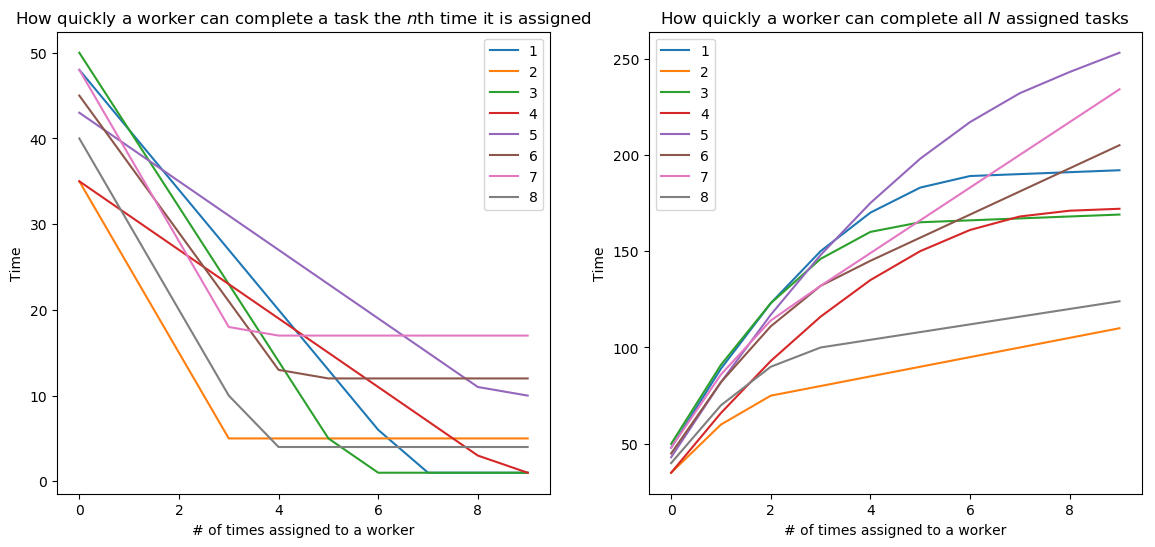

In [10]:
# Worker task learning
###########
quotas = rand(quotaRange,1,m_tasks) # 5 types of tasks with random quotas
horizon = maximum(quotas)
initial_task_lengths = rand(initialTaskLengthRange, m_tasks)
learning_speed = rand(learningSpeedRange, m_tasks)
min_task_lengths = max.(1, initial_task_lengths - rand(learningCurveMinLengthRange, m_tasks))

function completion_speeds(initial_length, min_length, learning_speed, horizon)
    n_tasks = size(min_length, 1)
    [(max.(min_length[j], initial_length[j]-T*learning_speed[j]))
        for j in 1:n_tasks, T in 0:horizon-1]
end

task_completion_speed = completion_speeds(initial_task_lengths, min_task_lengths, learning_speed, horizon)
task_bundle_times = cumsum(task_completion_speed, 2)

plot_learning_model(task_completion_speed, task_bundle_times)
show()

This information is used to calculate how much time a worker will require to complete each task they have been assigned.

Our optimization model can use any input data that describes how long a worker will take to finish $x$ tasks and so is extremely flexible in regards to how worker productivity is modeled.  We can easily extend our model to include individual worker abilities, worker learning rates per task, decreasing returns above a certain work assignment, and more.

In [11]:
# Model Solving
###############################

function solveBTB(n_workers, quotas, task_bundle_times)
    horizon = maximum(quotas)
    n_tasks = size(task_bundle_times,1)
    m = Model(solver=GurobiSolver(OutputFlag=0))
    @variable(m, work[1:n_workers, 1:n_tasks, 1:horizon], Bin)
    @variable(m, slowest_worker >= 0)

    @expression(m, work_on[j in 1:n_tasks], sum(work[i,j,t]*t for t in 1:horizon, i in 1:n_workers))

    # we must meet quotas
    @constraint(m, quota_constr[j in 1:n_tasks], work_on[j] >= quotas[j])

    # worker speed
    @expression(m, worker_speed[i in 1:n_workers],
        sum(sum(task_bundle_times[j, t] * work[i,j,t] for t in 1:horizon) for j in 1:n_tasks))

    # Each worker works on either 1 task, 2 tasks, 3 etc.
    for i in 1:n_workers, j in 1:n_tasks
        addSOS1(m, work[i,j,:])
    end

    # epigraph bound for slowest_worker
    @constraint(m, worker_speed .<= slowest_worker)

    # minimize the amount of time the slowest worker takes
    @objective(m, Min, slowest_worker)

    solve(m)
    
    getvalue(work), getobjectivevalue(m)
end

work, min_t = solveBTB(n_workers, quotas, task_bundle_times)
println("The minimum completion time is: ", min_t)

LoadError: [91mUndefVarError: @variable not defined[39m

After we find the optimal division of labor between our workers, we can construct a schedule that shows how much time each worker spends on each task type:

In [12]:
# Plotting worker schedule
##########################

# task_dur is a matrix where the rows represent workers and columns represent the total time spent working
# on a particular task type.
task_dur, L = α_to_durations(work, task_completion_speed)

plot_tasks(n_workers, m_tasks, task_dur, L)
show()

LoadError: [91mUndefVarError: work not defined[39m

One limitation of this model is that we cannot account for the effect of temporal assignment density on worker productivity.
However, the considerable increase in solving speed ([Section 4.A](#4.A-Model-Solving-Speed)) allow us to simulate much larger problems and analyze what potential speedup in project completion we can expect for large projects.

## 4. Results and discussion ##
First we analyze the solving speed of each model, and show how they scale as different parameters increase.  We focus on the comparison between Model 2 - Variety Assignments and Model 3 - Binary Task Bundles to show the increased efficiency in solving a problem without discrete time.

Next we analyze the the results from Binary Task Bundles to answer questions about the how the different initial conditions of worker skills and required tasks affect the optimal worker task assignments.  

### 4.A Model Solving Speed ###

We tested the time required to solve our three models with various numbers of workers, tasks, and task types to estimate the scaling potential as the problem size increases. This resulted in interesting relations between the number of tasks and number of workers on the solver time.

For each model, we scaled the size of one of the input parameters to the problem and compared the time to solve each problem relative to the original one-times scaling problem.  Code to generate this data can be found in the [Appendix](#Appendix).

### 4.A.a Simple Assignment Timing ### 

![](simple-assignment.png)

This problem scales very well for a mixed-integer program, and seems to be on the order of O(n) as both inputs scale.  A potentially interesting point in the second graph is when the scale factor is 10, we have the same number of workers and tasks, and so above this point there may be several workers who are never assigned a task.  However, this seems to have no impact on the solving speed of this model.  

### 4.A.b Variety Assignment Timing ###

![](variety-assignment.png)

We had significant difficult in analyzing this model because it solved very slowly and scaled horrendously.  We attempted to use similar values for this model and Binary Task Bundles, but the first run of our averaging took over 24 hours to complete.  We were forced to use fewer works, fewer task types, lower quota amounts, and significantly lower smaller scaling factors.  

**What do the plots say? Exponential?**

### 4.A.c Binary Task Bundles Timing ###

![](binary-task-bundles.png)

Again, we scaled the input variable sizes to our optimization problem to find how the problem scaled across different input dimensions.  Here, the curves are not smooth, implying that the problem does not scale cleanly as the variable size scales and instead is highly dependent on the input values.  This is evident in repeated runs of this averaging as the on each run, peaks in the scaling are evident and are not consistently in the same locations. However, even in the worst case secenarios changing each variable size was on the order of O(n).  

The exception to this is in the graph of Scaling Task Quotas. This graph has very extreme variations in the scaling, where at 18x scaling it seems to be O(n^2) but at 19x scaling, it becomes less than linear.  

Overall, this model is able to scale to extremely large problems and should still be able to solve them in a reasonable time.  

### 4.A.d Binary Task Bundles vs. Variety Assignment Timing ###

We are especially interested in comparing the solution speed of Binary Task Bundles and Variety Assignment to see if our relaxation of a solution is significantly faster.  The following plots contain the absolute solution time rather than the speed relative to one-times scaling.

![](solving-time-comparison.png)

** How do the solving speeds compare?**

### 4.B Data Interpretation###
**Interpret our 3rd model with different starting conditions of workers/tasks here**


### 4.B.a All workers have similar initial ability

In [6]:
n_workers = 5
n_tasks = 8
quotas = rand(5:10,1,n_tasks)
horizon = maximum(quotas)
initial_task_length = ones(n_tasks) * rand(30:50)
min_task_length = max.(1, initial_task_length - rand(30:50, n_tasks))
learning_speed = rand(4:10, n_tasks)

speeds = completion_speeds(initial_task_length, min_task_length, learning_speed, horizon)
bundle_times = cumsum(speeds,2)

plot_learning_model(speeds, bundle_times)

α, _ = solveBTB(n_workers, quotas, bundle_times)
task_dur, L = α_to_durations(α, speeds)
plot_tasks(n_workers, m_tasks, task_dur, L)
show()

LoadError: [91mUndefVarError: completion_speeds not defined[39m

### 4.B.b All workers skilled at one task

In [7]:
n_workers = 5
n_tasks = 8
quotas = rand(5:10,1,n_tasks)
horizon = maximum(quotas)
initial_task_length = rand(40:50, n_tasks)
initial_task_length[1] = round(.3 * initial_task_length[1])
min_task_length = max.(1, initial_task_length - rand(30:50, n_tasks))
learning_speed = rand(4:10, n_tasks)

speeds = completion_speeds(initial_task_length, min_task_length, learning_speed, horizon)
bundle_times = cumsum(speeds,2)

plot_learning_model(speeds, bundle_times)

α, _ = solveBTB(n_workers, quotas, bundle_times)
task_dur, L = α_to_durations(α, speeds)
plot_tasks(n_workers, m_tasks, task_dur, L)
show()

LoadError: [91mUndefVarError: completion_speeds not defined[39m

### 4.B.c All workers skilled at one task; short project

In [8]:
n_workers = 5
n_tasks = 8
quotas = rand(3:4,1,n_tasks)
horizon = maximum(quotas)
initial_task_length = rand(40:50, n_tasks)
initial_task_length[1] = round(.3 * initial_task_length[1])
min_task_length = max.(1, initial_task_length - rand(30:50, n_tasks))
learning_speed = rand(2:3, n_tasks)

speeds = completion_speeds(initial_task_length, min_task_length, learning_speed, horizon)
bundle_times = cumsum(speeds,2)

plot_learning_model(speeds, bundle_times)

α, _ = solveBTB(n_workers, quotas, bundle_times)
task_dur, L = α_to_durations(α, speeds)
plot_tasks(n_workers, m_tasks, task_dur, L)
show()

LoadError: [91mUndefVarError: completion_speeds not defined[39m

### 4.C Anything to discuss? ###

## 5. Conclusion ##

The goal of this project is to merge an assignment model with a task scheduling model and include nonlinear task completion time to closely model how a worker learning a new task will become more productive over time.  We discovered that to solve this problem exactly requires solving a quadratic assignment problem, which is unable to scale to the size of problem we want to solve.

As a result, we relaxed our problem, ignoring the order in which tasks are assigned to workers and instead focusing only on whether a task is assigned to a worker.
This significantly reduced the solution time and allowed us to interpret how workers should be assigned given a variety of initial worker skills and required tasks.
We simulated a worker learning-curve and were able to successfully analyze, given initial worker skills and learning rates, how to optimally allocate workers to tasks to minimize project completion time.
This allowed us to answer questions about when worker specialization is valuable and when generalized skills are more important.

There are still many different directions to take this project.
Perhaps there is a reformulation of our Variety Tasks model which could reduce the complexity of the problem.  There may be some assumptions which could reduce the size of the solution space, _e.g._ enforcing a tighter upper-bound on the time-scale of the problem.

Incorporating real-data into our model will allow to see if it is useful.
Perhaps learning rates are so low in comparison to a single project timeline that worker productivity can be approximated as constant.
If so, then the ordering of tasks is never important, which means that the Binary Task Bundle model is an appropriate relaxation of the problem.
In addition, with a constant productivity, the cost function becomes linear, reducing the Binary Task Bundles model into a linear program.
Knowing whether these assumptions are valid will require the use of real data.

We did not explore planning problems with task dependencies in our project.
It could be interesting to use the "House Construction" example from class and model the prerequisite task completion along with assigning workers to the individual tasks.
This likely becomes an even more complex quadratic assignment problem, but it would be interesting to find out how large of a problem size it can meaningfully scale to.

Another option for exploring a construction timeline is to integrate our Binary Task Bundles model as each task within the timeline. 
Within each timeline task, we have a set of subtasks that can be completed in any order.  These subtasks can be modeled with our Binary Task Bundles model.
The assumption here is that that the worker learning will not have a significant effect on the ordering of tasks in the project timeline, but the accumulated learning from each subtask over the course of an entire project may reduce the total time to complete a project.  

A final follow-up option would be to use the model to predict how productive a worker will be at some point in the future.
We could extend the SailCo problem from class, where we have an expected number of boats we need to deliver over the course of the next four months and we want to minimize the operations cost by minimizing the amount of overtime needed.
Instead of solely focusing on building a certain number of boats in advance, we can also consider the increase in worker production speed as they focus on a subtask of building a boat.
Can they become sufficiently productive within the timeframe to avoid working overtime?

Questions of how to assign workers tasks are important in almost every industry and are an important aspect of increasing operations efficiency. Developing tools to help predict how many individual decisions, such as whether a worker is assigned any of hundreds of tasks, impact an overarching project goal is an important part of finding out how efficiency can be increased. Our model seeks to address this by allowing a person to analyze how to assign tasks depending on worker skills to optimize the productivity on a project.

## Appendix ##

### Imports and Routines ###

In [13]:
using PyPlot, ProgressMeter
using JuMP, Gurobi

LoadError: [91mArgumentError: Module ProgressMeter not found in current path.
Run `Pkg.add("ProgressMeter")` to install the ProgressMeter package.[39m

In [1]:
# This function plots a horizontal bar graph to help visualize task assignment/completion for each worker over time.
# This function accepts arguments for the number of workers, n_workers, the number of task types, n_task_types, and 
# a matrix where the rows represent workers and the columns represent the duration that worker worked on a 
# certain task type, task_dur.
function plot_task_dur(n_workers, n_task_types, task_dur)
    ind = 1:n_workers
    width = 0.35
    
    figure(figsize=[5, 5])
    
    # Plot worker vs task type completion time
    left1 = zeros(n_workers)
    
    for j=1:size(task_dur, 2)
        barh(ind, task_dur[:, j], left=left1, label="Task Type $j")
        left1 = left1 + task_dur[:, j]
    end
    
    ylabel("Worker")
    xlabel("Time Units")
    title("Time spent on tasks")
    legend(loc="center left", bbox_to_anchor=(1, 0.5))
    yticks(1:n_workers)
end

# This function plots a learning model in two plots:
#  * how long a task will take as a function of the number of times it has been assigned for a given worker
#  * how long N tasks will take for a given worker to complete, as a function of N
function plot_learning_model(task_completion_speed, task_bundle_times)
    n = size(task_completion_speed,1)
    figure(figsize=[14, 6])
    subplot(121); plot(task_completion_speed')
    legend(1:n); xlabel("# of times assigned to a worker"); ylabel("Time")
    title("How quickly a worker can complete a task the \$n\$th time it is assigned");
    subplot(122); plot(task_bundle_times')
    legend(1:n); xlabel("# of times assigned to a worker"); ylabel("Time")
    title("How quickly a worker can complete all \$N\$ assigned tasks");
end

# This function plots a horizontal bar graph to help visualize task assignment/completion for each worker.
# This function accepts arguments for the number of workers, n_workers, the number of task types, n_task_types, and 
# a matrix where the rows represent workers and the columns represent the duration that worker worked on a 
# certain task type, task_dur. task_amt is, for each worker (row) and for each task type (column), how many tasks
# a worker completed.
function plot_tasks(n_workers, n_task_types, task_dur, task_amt)
    ind = 1:n_workers
    width = 0.35
    fig = figure(figsize=[14, 6])
    
    # Plot worker vs task type completion time
    left1 = zeros(n_workers)
    ax1 = fig[:add_subplot](1, 2, 1)
    
    for j=1:size(task_dur, 2)
        ax1[:barh](ind, task_dur[:, j], left=left1, label="Task Type $j")
        left1 = left1 + task_dur[:, j]
    end
    
    ax1[:set_ylabel]("Worker")
    ax1[:set_xlabel]("Time Units")
    ax1[:set_title]("Time spent on tasks")
    ax1[:set_yticks](1:n_workers)
    
    # Plot worker vs number of tasks completed
    left2 = zeros(n_workers)
    ax2 = fig[:add_subplot](1, 2, 2)
    
    for j=1:size(task_amt, 2)
        ax2[:barh](ind, task_amt[:, j], left=left2, label="Task Type $j")
        left2 = left2 + task_amt[:, j]
    end
    
    ax2[:set_ylabel]("Worker")
    ax2[:set_xlabel]("Work Units")
    ax2[:set_title]("Work units spent on tasks")
    ax2[:legend](loc="center left", bbox_to_anchor=(1, 0.5))
    ax2[:set_yticks](1:n_workers)
end

# This function converts the output of the model to a
# matrix of durations task_dur for which a worker worked on a given task,
# and a matrix L of the number of times a worker worked on a given task.
function α_to_durations(α, task_speeds)
    L = round.(Int, sum(α[:,:,i]*i for i=1:horizon))
    task_dur = zeros(n_workers, m_tasks)

    for i=1:n_workers
        for j=1:m_tasks
            for k=1:L[i, j]
                task_dur[i, j] = task_dur[i, j] + task_speeds[j, k]
            end
        end
    end
    
    task_dur, L
end

α_to_durations (generic function with 1 method)

### Model Solving Speed Code

**WARNING** The following code blocks take approximately 48 hours to run!

In [2]:
env = Gurobi.Env()

function simpleModel(N,M)
    T = N #upper bound on project completion

    #m = Model(solver=CbcSolver)
    m = Model(solver=GurobiSolver(env, OutputFlag=0))

    @variable(m, x[1:N, 1:M, 1:T], Bin)
    @variable(m, last)

    # due to the following two constraints, this just selects the time
    # when x[j, i, t] = 1, since x[j, :, :] has only one nonzero elemnt
    @expression(m, start_t[j=1:N], sum(x[j, i, t] * t for i=1:M for t=1:T))

    # at most one job per timestep per person
    @constraint(m, [t=1:T, i=1:M], sum(x[:, i, t]) <= 1)

    # each task is only worked on once
    @constraint(m, [j=1:N], sum(x[j, :, :]) == 1)

    # min { max_j end_t[j] }
    @constraint(m, [j=1:N], last >= start_t[j] + 1)

    @objective(m, Min, last)

    solve(m)
    timer = getsolvetime(m)
    return timer
end
                
function discreteTimeModel(N,W)
    # Task/Worker Parameters
    ###############################

    ## We require 5 of task_1, 1 of task_2, etc.
    n = maximum(N) #max number of tasks for a category
    v = size(N,1) # number of types of tasks

    ## Each row of W is a worker, and the column is the time required for the worker to complete that task
    w = size(W,1) #number of workers

    T = convert(Int64,maximum(W)*sum(N)) #upper bound on project completion

    # Solver
    ###############################
    m = Model(solver=GurobiSolver(env, OutputFlag=0))

    @variable(m, x[1:n, 1:v, 1:w, 1:T], Bin) # true when a worker starts a task
    @variable(m, z[1:n, 1:v, 1:w, 1:T], Bin) #true if a worker is working on a task (extends x with task length)

    @variable(m, last)

    #If a worker starts a task at time t, z if true until the tasks completes
    for i=1:n
        for j=1:v
            for k=1:w
                for t=1:T
                    if t < T-convert(Int64,W[k,j])
                        @constraint(m, [l=1:convert(Int64,W[k,j])], z[i,j,k,t+l-1] >= x[i,j,k,t])  
                    else
                        @constraint(m, [l=0:T-t], z[i,j,k,t+l] >= x[i,j,k,t])  
                    end
                end
            end
        end
    end

    #only one task in z can be worked simultaneously
    @constraint(m, [k=1:w, t=1:T], sum(z[:,:,k,t]) <= 1)

    #expression is used as an epigraph to find the end time of the last task
    @expression(m, end_t[j=1:n, k=1:v, i=1:w, t=1:T], (z[j,k,i,t])*(t+W[i,k]))
    @expression(m, start_t[j=1:n, k=1:v, i=1:w], sum((x[j,k,i,t])*(t) for t=1:T))

    # at most one job per timestep per person
    @constraint(m, [t=1:T, i=1:w], sum(x[:, :, i, t]) <= 1)

    # each task is only worked on once and all tasks are completed
    @constraint(m, [j=1:n, i=1:v], sum(x[j, i, :, :]) <= 1)
    @constraint(m, [i=1:v], sum(x[:,i,:,:]) == N[i])

    # min { max_j end_t[j] }
    @constraint(m, [j=1:n, k=1:v, i=1:w, t=1:T], last >= end_t[j,k,i,t])

    @objective(m, Min, last)    
    solve(m)
    timer = getsolvetime(m)
    return timer
end
                
function binaryTaskBundles(quotas, n_workers)
  
    # Task/Worker Parameters
    ###############################
    m_tasks = length(quotas)
    horizon = maximum(quotas)

    initial_task_lengths = rand(1:10, m_tasks)
    min_task_lengths = max.(1, initial_task_lengths - rand(1:10, m_tasks))
    task_bundle_times = [sum(max(min_task_lengths[j], initial_task_lengths[j]-t) for t in 1:T) for j in 1:m_tasks, T in 1:horizon]

    ###############################

    m = Model(solver=GurobiSolver(env, OutputFlag=0))
    @variable(m, work[1:n_workers, 1:m_tasks, 1:horizon], Bin)
    @variable(m, slowest_worker >= 0)

    @expression(m, work_on[j in 1:m_tasks], sum(work[i,j,t]*t for t in 1:horizon, i in 1:n_workers))

    # we must meet quotas
    @constraint(m, quota_constr[j in 1:m_tasks], work_on[j] >= quotas[j])

    # worker speed
    @expression(m, worker_speed[i in 1:n_workers],
        sum(sum(task_bundle_times[j, t] * work[i,j,t] for t in 1:horizon) for j in 1:m_tasks))

    for i in 1:n_workers, j in 1:m_tasks
        addSOS1(m, work[i,j,:])
    end

    # ∞-norm epigraph bounds for slowest_worker
    @constraints(m, begin
        worker_speed .<= slowest_worker
        -slowest_worker .<= worker_speed
    end)

    # minimize the amount of time the slowest worker takes
    @objective(m, Min, slowest_worker)
    
    solve(m)
    timer = getsolvetime(m)
    return timer
end

## have consistent scale factor and averages
scaleFactor = 20
averages = 5

5

Academic license - for non-commercial use only


#### Model 1 - Tasks

5 workers, number of tasks ranges from 5 to 100.

Academic license - for non-commercial use only


[1]: 100%|██████████████████████████████████████████████| Time: 0:00:09
[2]: 100%|██████████████████████████████████████████████| Time: 0:00:09
[3]: 100%|██████████████████████████████████████████████| Time: 0:00:10
[4]: 100%|██████████████████████████████████████████████| Time: 0:00:09
[5]: 100%|██████████████████████████████████████████████| Time: 0:00:09


Relative speed: 

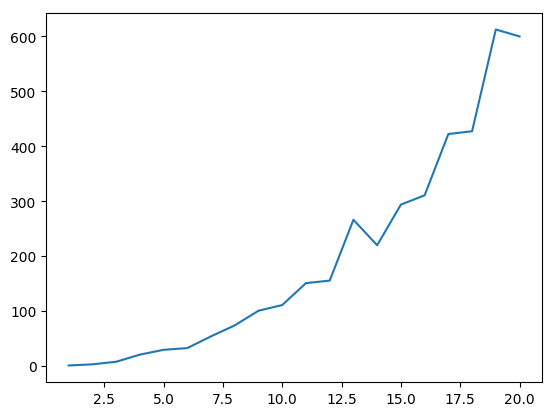

[1.0, 3.09693, 7.78217, 20.7263, 29.5446, 32.6379, 54.031, 74.0044, 100.637, 111.023, 150.907, 155.476, 266.185, 219.875, 293.831, 310.689, 422.281, 427.334, 612.598, 599.941]
Timer to solve: [0.00210152, 0.00650826, 0.0163544, 0.0435566, 0.0620884, 0.068589, 0.113547, 0.155521, 0.211489, 0.233316, 0.317133, 0.326735, 0.559392, 0.462072, 0.617491, 0.652917, 0.88743, 0.898049, 1.28739, 1.26079]


In [15]:
timer = zeros(scaleFactor)

N = 5; W= 5 # task, worker, time inital values
for p=1:averages
    @showprogress "[$p]: " for u=1:scaleFactor
        timer[u] = timer[u] + simpleModel(N*u,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Model 1 - Workers

60 tasks; workers vary from 5 to 100.

[1]: 100%|██████████████████████████████████████████████| Time: 0:00:47
[2]: 100%|██████████████████████████████████████████████| Time: 0:00:44
[3]: 100%|██████████████████████████████████████████████| Time: 0:00:44
[4]: 100%|██████████████████████████████████████████████| Time: 0:00:44
[5]: 100%|██████████████████████████████████████████████| Time: 0:00:46


Relative speed: 

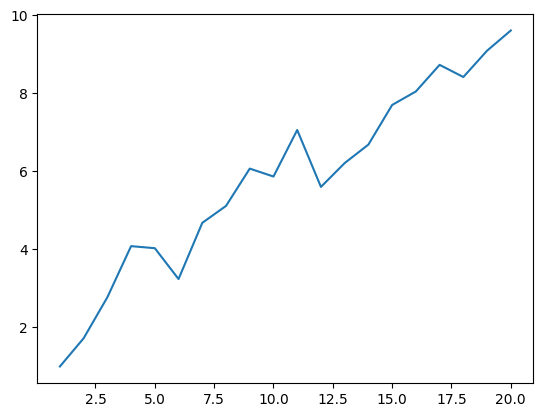

[1.0, 1.72282, 2.77417, 4.0856, 4.03265, 3.24188, 4.68263, 5.11684, 6.07342, 5.87066, 7.06376, 5.60419, 6.21554, 6.68937, 7.70519, 8.05168, 8.73347, 8.42148, 9.09657, 9.6151]
Timer to solve: [0.328386, 0.565751, 0.910998, 1.34165, 1.32427, 1.06459, 1.53771, 1.6803, 1.99442, 1.92784, 2.31964, 1.84034, 2.04109, 2.19669, 2.53027, 2.64405, 2.86794, 2.76549, 2.98718, 3.15746]


In [3]:
timer = zeros(scaleFactor)

N = 60; W= 5 # task, worker, time inital valuesN = 5; W= 5 # task, worker, time inital values
for p=1:averages
    @showprogress "[$p]: " for u=1:scaleFactor
        timer[u] = timer[u] + simpleModel(N,W*u,)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Model 2 - Tasks 

Number of workers and task types held constant; total number of tasks scales.

In [ ]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker value
    N = rand(8:12,1,5)
    W = rand(1:10,5,5)
    @showprogress "[$p]: " for u=1:scaleFactor
        timer[u] = timer[u] + discreteTimeModel(N*u,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Model 2 - Workers

Number of tasks and types of tasks held constant; number of workers scales.

In [ ]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(8:12,1,5)
    W = rand(1:10, 5,5)
    @showprogress "[$p]: " for u=1:scaleFactor
        W = [W; rand(1:10, 5,5)]
        timer[u] = timer[u] + discreteTimeModel(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Model 2 - Task Variety
Number of workers and tasks held constant; variety of task types scales.

In [ ]:
timer = zeros(scaleFactor)


for p=1:averages
    # task, worker values
    N = 100
    W = rand(1:10,5,1)
    timer[1] = timer[1] + discreteTimeModel(N,W)
    @showprogress "[$p]: " for u=2:scaleFactor
        N = round.(Int, 100/u * ones(u))
        W = [W rand(1:10, 5,1)]
        timer[u] = timer[u] + discreteTimeModel(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Model 2 - Task Variety, tasks number scales accordingly.
Number of workers constant; variety of task types scales, and each task is done the same number of times.

In [ ]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(8:12,1,1)
    W = rand(1:10,5,1)
    time[1] = time[1] + discreteTimeModel(N,W)
    @showprogress "[$p]: " for u=2:scaleFactor
        N = [N rand(8:12,1,1)]
        W = [W rand(1:10, 5,1)]
        timer[u] = timer[u] + discreteTimeModel(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Binary Task Bundles - Workers
n_tasks, quotas constant; n_workers is scaled.

[1]: 100%|██████████████████████████████████████████████| Time: 0:00:01
[2]: 100%|██████████████████████████████████████████████| Time: 0:00:02
[3]: 100%|██████████████████████████████████████████████| Time: 0:00:02
[4]: 100%|██████████████████████████████████████████████| Time: 0:00:02
[5]:  95%|████████████████████████████████████████████  |  ETA: 0:00:00

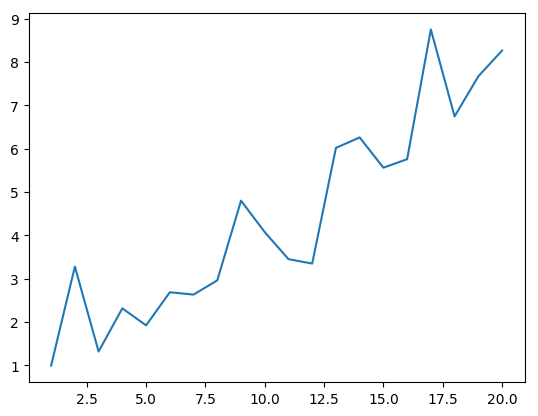

Relative speed: [1.0, 3.28005, 1.32265, 2.31771, 1.92508, 2.68866, 2.63472, 2.96296, 4.80099, 4.07607, 3.45218, 3.3502, 6.01776, 6.25936, 5.56142, 5.75758, 8.7491, 6.74437, 7.66818, 8.26274]
Timer to solve: [0.0186203, 0.0610756, 0.0246281, 0.0431564, 0.0358456, 0.0500637, 0.0490593, 0.0551712, 0.0893959, 0.0758976, 0.0642807, 0.0623817, 0.112053, 0.116551, 0.103555, 0.107208, 0.162911, 0.125582, 0.142784, 0.153855]


[5]: 100%|██████████████████████████████████████████████| Time: 0:00:02


In [16]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(8:12,1,5)
    @showprogress "[$p]: " for u=1:scaleFactor
        W = 5*u
        timer[u] = timer[u] + binaryTaskBundles(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Binary Task Bundles - Tasks
Number of workers and number of task types is constant; number of tasks scales.

In [ ]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(8:12,1,5)
    W = 5
    timer[1] = timer[1] + binaryTaskBundles(N,W)
    @showprogress "[$p]: " for u=1:scaleFactor
        timer[u] = timer[u] + binaryTaskBundles(N*u,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

[1]:  75%|██████████████████████████████████            |  ETA: 0:00:03

#### Binary Task Bundles - Task Type
Number of workers and total tasks are constant; number of task types scales.

In [ ]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = 100
    W = 5
    timer[1] = timer[1] + binaryTaskBundles(N,W)
    @showprogress "[$p]: " for u=2:scaleFactor
        N = round.(Int, 100/u * ones(u))
        timer[u] = timer[u] + binaryTaskBundles(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Binary Task Bundles - Tasks and Variety
Number of workers held constant; number of tasks scales, and total quota scales.

In [ ]:
timer = zeros(scaleFactor)

for p=1:averages
    # task, worker values
    N = rand(8:12,1,1)
    W = 5
    timer[1] = timer[1] + binaryTaskBundles(N,W)
    @showprogress "[$p]: " for u=2:scaleFactor
        N = [N rand(8:12,1,1)]
        timer[u] = timer[u] + binaryTaskBundles(N,W)
    end
end

timer= timer./averages
speed = timer./timer[1]

plot(1:scaleFactor,speed)
println("Relative speed: ", speed)
println("Timer to solve: ", timer)

#### Simple Assignment Timing Plots

In [ ]:
### Simple Assignment Data ###
#Scaling Tasks
SM1 =[1.0, 0.57143, 2.24756, 4.53919, 4.63766, 7.00508, 11.2083, 16.7623, 23.5657, 23.0381, 25.2694, 28.7922, 52.7929, 42.8318, 58.7976, 61.3877, 82.5161, 83.5397, 103.553, 111.489]
#Scaling workers
SM2=[1.0, 1.96746, 2.64001, 4.58475, 4.01553, 3.05895, 4.23258, 4.39835, 5.4244, 5.63077, 6.37447, 5.20242, 5.75265, 6.01087, 6.86303, 7.13417, 7.9541, 7.65064, 8.60955, 8.88195]

n = 20 

fig = figure("pyplot_subplot_mixed",figsize=(10,5)) # Create a new blank figure
subplot(121); plot(1:n, SM1); 
title("Scaling Tasks"); xlabel("Scale Factor"); ylabel("Relative Solving Time")
annotate("Task Quota: 5*s \nWorkers: 5 \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(122); plot(1:n, SM2); 
title("Scaling Workers"); xlabel("Scale Factor"); ylabel("Relative Solving Time")
annotate("Task Quotas: 60 \nWorkers: 5*s \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

suptitle("Simple Assignment")
show()
savefig("simple-assignment.png")

#### Variety Assignment Timing Plots

In [ ]:
### Variety Assignment ###
# Scaling tasks
VA1=[1.0, 13.9232, 71.6988, 331.081, 1624.28, 2588.54, 9035.07]
#Scaling of workers
VA2=[1.0, 2.00397, 4.62821, 7.64477, 10.8158, 20.9566, 14.5778]
# Scaling Task Variety, constant # of tasks
VA3=[1.0, 0.592412, 0.539217, 0.404689, 0.365005, 0.233833, 0.462855]
#scaling Task variety and tasks
VA4=[1.0, 7.31853, 18.9964, 35.4565, 66.0749, 105.345, 198.716]

n=7

fig = figure("pyplot_subplot_mixed",figsize=(10,10)) # Create a new blank figure
subplot(221); plot(1:n, VA1);
title("Scaling Task Quotas"); xlabel("Scaling Factor"); ylabel("Relative Solving Time")
annotate("Workers: 3 \nTask Variety: 3 \nTask Quota: (3-5 iid)*s \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(222); plot(1:n, VA2);
title("Scaling Workers"); xlabel("Scaling Factor"); ylabel("Relative Solving Time")
annotate("Workers: 2*s \nTask Variety: 5 \nTask Quota: 3-5 iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(223); plot(1:n, VA3); 
title("Scaling Task Varieties"); xlabel("Scaling Factor"); ylabel("Relative Solving Time")
annotate("Workers: 3 \nTask Variety: s \nTask Quota: 20/s iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(224); plot(1:n, VA4); 
title("Scaling Task Varieties and Quotas"); xlabel("Scaling Factor"); ylabel("Relative Solving Time")
annotate("Workers: 3 \nTask Variety: s \nTask Quota: 8-12 iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

suptitle("Variety Assignment")
fig[:canvas][:draw]() # Update the figure
gcf(); # Needed for IJulia to plot inline
savefig("variety-assignment.png")

#### Binary Task Bundle Timing Plots

In [ ]:
### Binary Task Bundles ###
# Scaling tasks
BTB1=[1.0, 0.944222, 2.5731, 38.0854, 2.48491, 13.8282, 5.31442, 4.72224, 105.985, 4.74393, 112.438, 86.0962, 13.4782, 378.049, 88.5545, 19.5509, 204.36, 1050.04, 21.6221, 24.308]
#Scaling of workers
BTB2=[1.0, 1.6499, 3.12206, 1.69142, 1.45761, 1.28982, 1.60874, 1.65788, 1.37557, 2.55686, 2.46518, 2.24998, 2.11663, 2.45685, 3.17194, 3.41251, 3.20084, 3.06863, 5.37571, 4.77939]
# Scaling Task Variety, constant # of tasks
BTB3=[1.0, 2.21394, 3.30483, 12.5813, 3.89896, 2.70547, 2.3188, 54.2228, 1.85634, 1.72128, 3.55493, 1.19017, 0.707801, 0.664048, 1.6138, 1.15357, 0.658361, 0.672043, 0.690194, 0.559427]
#scaling Task variety and tasks
BTB4=[1.0, 4.05839, 8.47072, 10.9791, 16.0322, 24.9183, 41.0167, 13.3069, 18.9344, 21.4122, 25.8966, 27.4978, 31.2693, 24.9586, 14.7793, 10.6125, 10.9213, 13.5665, 18.0256, 20.6252]

n=20

fig = figure("pyplot_subplot_mixed",figsize=(10,10)) # Create a new blank figure
subplot(221); plot(1:n, BTB1)
title("Scaling Task Quotas"); xlabel("Scaling Factor"); ylabel("Relative Solving Time")
annotate("Workers: 5 \nTask Variety: 5 \nTask Quota: (8-12 iid)*s \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(222); plot(1:n, BTB2)
title("Scaling Workers"); xlabel("Scaling Factor"); ylabel("Relative Solving Time")
annotate("Workers: 5*s \nTask Variety: 5 \nTask Quota: 8-12 iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(223); plot(1:n, BTB3)
title("Scaling Task Varieties"); xlabel("Scaling Factor"); ylabel("Relative Solving Time")
annotate("Workers: 5 \nTask Variety: s \nTask Quota: 100/s iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(224); plot(1:n, BTB4)
title("Scaling Task Varieties and Quotas"); xlabel("Scaling Factor"); ylabel("Relative Solving Time")
annotate("Workers: 5 \nTask Variety: s \nTask Quota: 8-12 iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

suptitle("Binary Task Bundles")
fig[:canvas][:draw]() # Update the figure
gcf(); # Needed for IJulia to plot inline
savefig("binary-task-bundles.png")

#### Binary Task Bundles vs. Variety Assignment Timing Plots

In [ ]:
### Binary Task Bundles ###
# Scaling tasks
BTB1=[0.0107128, 0.00660782, 0.00971184, 0.0448559, 0.0304382, 0.0342438, 0.102228]
#Scaling of workers
BTB2=[0.00899849, 0.00650749, 0.00720901, 0.0144176, 0.00850754, 0.0115124, 0.0109135]
# Scaling Task Variety, constant # of tasks
BTB3=[0.00290298, 0.00420532, 0.00460625, 0.00610542, 0.0119122, 0.00510139, 0.00490608]
#scaling Task variety and tasks
BTB4=BTB3=[0.0025013, 0.00470428, 0.00620728, 0.0111115, 0.0129139, 0.0141155, 0.0106106]

### Variety Assignment ###
# Scaling tasks
VA1=[0.805015, 11.2084, 57.7186, 266.525, 1307.57, 2083.81, 7273.37]
#Scaling of workers
VA2=[2.78291, 5.57686, 12.8799, 21.2747, 30.0995, 58.3202, 40.5689]
# Scaling Task Variety, constant # of tasks
VA3=[24.6548, 14.6058, 13.2943, 9.97754, 8.99915, 5.76513, 11.4116]
#scaling Task variety and tasks
VA4=[1.10657, 8.09846, 21.0209, 39.2351, 73.1165, 116.572, 219.893]

n = 7

fig = figure("pyplot_subplot_mixed",figsize=(10,10)) # Create a new blank figure
subplot(221); p1 = semilogy(1:n,BTB1, label="BTB"); p1=semilogy(1:n, VA1, label="VA"); legend(loc="upper right")
title("Scaling Task Quotas"); xlabel("Scaling Factor"); ylabel("Absolute Solving Time")
annotate("Workers: 5 \nTask Variety: 3 \nTask Quota: (15-20 iid)*s \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(222); p2=semilogy(1:n, BTB2, label="BTB"); p2=semilogy(1:n, VA2, label="VA"); legend(loc="upper right")
title("Scaling Workers"); xlabel("Scaling Factor"); ylabel("Absolute Solving Time")
annotate("Workers: 5*s \nTask Variety: 3 \nTask Quota: 15-20 iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(223); p3=semilogy(1:n, BTB3, label="BTB"); p3=semilogy(1:n, VA3, label="VA"); legend(loc="upper right")
title("Scaling Task Varieties"); xlabel("Scaling Factor"); ylabel("Absolute Solving Time")
annotate("Workers: 5 \nTask Variety: s \nTask Quota: 50/s iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

subplot(224); p4=semilogy(1:n, BTB4, label="BTB"); p4=semilogy(1:n, VA4, label="VA"); legend(loc="upper right")
title("Scaling Task Varieties and Quotas"); xlabel("Scaling Factor"); ylabel("Absolute Solving Time")
annotate("Workers: 5 \nTask Variety: s \nTask Quota: 8-12 iid \nAverages: 5", 
           xy=[0.05;0.95], xycoords="axes fraction", ha="left",va="top")

suptitle("Solving Time Comparison")
fig[:canvas][:draw]() # Update the figure
gcf(); # Needed for IJulia to plot inline
savefig("solving-time-comparison.png")